In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import torch
import torch.nn as nn
from torch.nn import init
import torchaudio
import math, random
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.utils.data as data_utils
import torch.nn.functional as F

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
#from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
dataset='C:/Users/Eman Badr/Downloads/data/GroundType1/'

ID=[]
label=[]
ClassID=[]
 
# iterate over files in that directory

for folder in os.listdir(dataset):                               #go into the directory
    for filename in os.listdir(dataset+ str(folder)):          #go in every class 
        f = os.path.join(dataset+ str(folder), filename) #scan through every file in that class
        if os.path.isfile(f):
            ID.append(f.split('\\')[-1])
            label.append(str(folder))
            
for i in range(len(label)):
    if(label[i]=='Concrete'):
        ClassID.append(0) 
    elif(label[i]=='Flatmountain'):
        ClassID.append(1)
    else:
        ClassID.append(2)


In [3]:
dset=pd.DataFrame()
dset['ID']=ID
dset['label']=label
dset['ClassID']=ClassID


In [4]:
dset.head(599)

,ID,label,ClassID
0,Concrete-01.wav,Concrete,0
1,Concrete-02.wav,Concrete,0
2,Concrete-03.wav,Concrete,0
3,Concrete-04.wav,Concrete,0
4,Concrete-05.wav,Concrete,0
...,...,...,...
594,Grass-94.wav,Grass,2
595,Grass-95.wav,Grass,2
596,Grass-96.wav,Grass,2
597,Grass-97.wav,Grass,2


In [5]:
dset.to_csv('C:/Users/Eman Badr/Downloads/data/data.csv')

In [6]:
df = pd.read_csv('C:/Users/Eman Badr/Downloads/data/data.csv')

In [7]:
df['ID'].loc[150]

'Concrete-50.wav'

In [8]:
Grass = 'C:/Users/Eman Badr/Downloads/data/GroundType1/Grass/'
path=os.path.join(Grass, df['ID'].loc[595])
print(path)

C:/Users/Eman Badr/Downloads/data/GroundType1/Grass/Grass-95.wav


Shape of waveform: torch.Size([1, 156000])
Sample rate of waveform: 48000
(tensor([[-9.5856e-02, -8.4930e-02, -7.0007e-02,  ...,  6.1035e-05,
          1.3672e-02,  2.6642e-02]]), 48000)


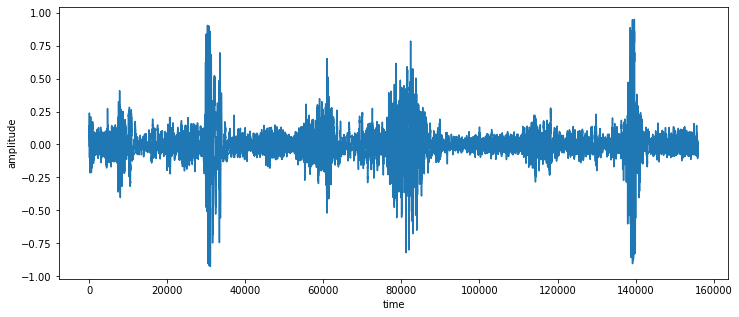

In [9]:
def plot_audio(filename):
    waveform, sample_rate = torchaudio.load(filename)

    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    fig1, ax1 = plt.subplots(figsize=(12, 5))    
  
    ax1.plot(waveform[0,:].numpy())

    ax1.set_xlabel('time') 
    ax1.set_ylabel("amplitude")

    return waveform, sample_rate


aud= plot_audio(path)
print(aud)

Shape of spec: torch.Size([1, 64, 305])
Shape of spec: torch.Size([1, 64, 305])


tensor([[[ 25.5493,  21.3841,  22.3438,  ...,  -3.5486,  12.9258,  15.9601],
         [ 27.8234,  25.0760,  25.8150,  ...,   3.6385,  11.6593,  20.3916],
         [ 24.6822,  27.2284,  24.1783,  ...,  11.5164,  10.3024,  18.8846],
         ...,
         [-31.9133, -36.2757, -35.0923,  ..., -36.1378, -36.3619, -35.0219],
         [-29.8891, -35.5567, -35.3948,  ..., -33.3156, -36.0309, -33.8310],
         [-29.4297, -34.2287, -34.1284,  ..., -34.9304, -34.0786, -34.0415]]])

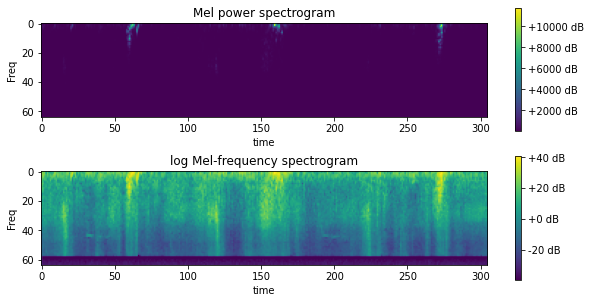

In [10]:
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, sr = aud
    top_db = 80
    
    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec1 = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec1)
    
    
    print("Shape of spec: {}".format(spec1.size()))
    print("Shape of spec: {}".format(spec.size()))
     
    fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True,  figsize=(10, 5))
   
    
    s= ax[0].imshow(spec1[0,:,:].numpy())
    s1= ax[1].imshow(spec[0,:,:].numpy())
    ax[0].grid(False)
    ax[1].grid(False)
    fig.colorbar(s, ax=ax[0], format='%+2.0f dB') 
    fig.colorbar(s1, ax=ax[1], format='%+2.0f dB')    
    ax[0].set_title('Mel power spectrogram') 
    ax[0].set_xlabel('time') 
    ax[0].set_ylabel("Freq")
    
    ax[1].set_title('log Mel-frequency spectrogram')
    ax[1].set_xlabel('time') 
    ax[1].set_ylabel("Freq")


    return (spec)


spectro_gram(aud)

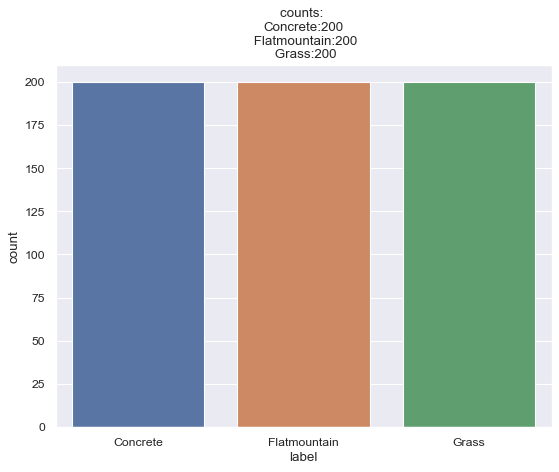

In [11]:
plt.figure(figsize=(8,6),dpi=80)
sn.set_theme(style="darkgrid")
sn.countplot(x ='label',data=dset)
plt.title('counts: \n' +'Concrete:'+str(dset.label.value_counts()[0])+'\n Flatmountain:'+str(dset.label.value_counts()[1])+'\n Grass:'+str(dset.label.value_counts()[2]))
plt.show()

In [12]:
print(dset.label.unique())

['Concrete' 'Flatmountain' 'Grass']


In [13]:
print("Number of training examples=", dset.shape[0], "  Number of classes=", len(dset.label.unique()))

Number of training examples= 600   Number of classes= 3


In [14]:
# Read file

df['ID'] = df['label'].astype(str) + '/' + df['ID'].astype(str)
# Take relevant columns
df = df[['ID', 'ClassID']]
df.head(350)

,ID,ClassID
0,Concrete/Concrete-01.wav,0
1,Concrete/Concrete-02.wav,0
2,Concrete/Concrete-03.wav,0
3,Concrete/Concrete-04.wav,0
4,Concrete/Concrete-05.wav,0
...,...,...
345,Flatmountain/Flat mountain road-45.wav,1
346,Flatmountain/Flat mountain road-46.wav,1
347,Flatmountain/Flat mountain road-47.wav,1
348,Flatmountain/Flat mountain road-48.wav,1


In [15]:
class AudioUtil():
    def open(audio_file): # Load an audio file. Return the signal as a tensor and the sample rate
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    
    def resample(aud, newsr):
        sig, sr = aud
  
        if (sr == newsr):# Nothing to do
            #print('newsr',newsr)
            return aud

        num_channels = sig.shape[0]# Resample first channel
        #print('num_channels',num_channels)
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        #print("Shape of transformed waveform: {}".format(resig.size()))

        #plt.figure()
        #plt.plot(resig[0,:].numpy())
        #print('resig',resig)
        #print('resig',resig.shape)

        return (resig, newsr)
    
    

    def pad_trunc(aud, max_ms):
        sig, sr = aud
        #print('sig',sig)
        #print('sr',sr)
        #print(sig.shape)
        num_rows, sig_len = sig.shape
        #print('num_rows',num_rows)
        #print('sig_len',sig_len)
        max_len = sr//1000 * max_ms
        #print('max_len',max_len)

        if (sig_len > max_len): # Truncate the signal to the given length
           sig = sig[:,:max_len]
           #print('sig_pad_trunc',sig.shape)
           #plt.figure()
           #plt.plot(sig[0,:].numpy())
         

        elif (sig_len < max_len): # Length of padding to add at the beginning and end of the signal
              pad_begin_len = random.randint(0, max_len - sig_len)
              #print('pad_begin_len',pad_begin_len)
              pad_end_len = max_len - sig_len - pad_begin_len
              #print('pad_end_len',pad_end_len)
              # Pad with 0s
              pad_begin = torch.zeros((num_rows, pad_begin_len))
              #print('pad_begin',pad_begin)
              pad_end = torch.zeros((num_rows, pad_end_len))
              sig = torch.cat((pad_begin, sig, pad_end),1) 
              #print('sig_pad_trunc', sig.shape)
              #plt.figure()
              #sig1=sig[0,:].numpy()
              #plt.plot(sig1)      
                                     
        return (sig, sr)          
                                      

    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80
    
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        #print("Shape of spec: {}".format(spec.size()))
        return (spec)
    
        #def play_audio(waveform, sample_rate):
        #display(Audio(waveform[0], rate=sample_rate))
        
        


In [16]:
 #dataset=[]
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 48000
        dataset=[]  
        # ----------------------------
        # Number of items in dataset
        # ----------------------------
    def __len__(self):
        return len(self.df)    
    
       # ----------------------------
       # Get i'th item in dataset
       # ----------------------------
    def __getitem__(self, idx):
       # Absolute file path of the audio file - concatenate the audio directory with the relative path
       audio_file = self.data_path + self.df.loc[idx, 'ID']
       #print(audio_file)

       class_id = self.df.loc[idx, 'ClassID']
        
       ID = self.df.loc[idx, 'ID']

       aud = AudioUtil.open(audio_file)

       reaud = AudioUtil.resample(aud, self.sr)

       dur_aud= AudioUtil.pad_trunc(reaud, self.duration)
       #print(dur_aud)
    
       sgram_features = AudioUtil.spectro_gram(dur_aud)
        
       #listen = AudioUtil.play_audio(dur_aud,self.sr)
       #inputs_m, inputs_s = sgram_features.mean(), sgram_features.std()
       #sgram_features = (sgram_features - inputs_m) / inputs_s


       return  sgram_features , class_id 

In [17]:
myds = SoundDS(df, dataset)

print(myds[20])


(tensor([[[-36.9972, -36.9972, -36.9972,  ..., -36.9972, -36.9972, -36.9972],
         [-36.9972, -36.9972, -36.9972,  ..., -36.9972, -36.9972, -36.9972],
         [-36.9972, -36.9972, -36.9972,  ..., -36.9972, -36.9972, -36.9972],
         ...,
         [-36.9972, -36.9972, -36.9972,  ..., -36.9972, -36.9972, -36.9972],
         [-36.9972, -36.9972, -36.9972,  ..., -36.9972, -36.9972, -36.9972],
         [-36.9972, -36.9972, -36.9972,  ..., -36.9972, -36.9972, -36.9972]]]), 0)


In [18]:
# data loader

random_seed = 64
torch.manual_seed(random_seed)




# Create training and validation data loaders
train_loader = torch.utils.data.DataLoader(myds, batch_size= 600, shuffle=False)
#print(train_loader,'len(train_loader)')

#for i, batch in enumerate(train_loader):
   #print(i, batch)
   #print(batch.shape)

In [19]:
examples = iter(train_loader)
data= examples.next()

#print(' '.join(f'{classes[targets[j]]:5s}' for j in range(batch_size)))



#examples = iter(test_loader)
#example_data,example_targets= examples.next()
#print(example_data.shape, example_targets.shape)
#print(' '.join(f'{classes[example_targets[j]]:5s}' for j in range(batch_size)))

In [20]:
data2 = data[0].reshape(len(data[0]),-1)

print(data[0].shape)
print(data2)
print(data2.shape)

torch.Size([600, 1, 64, 376])
tensor([[-36.0752, -36.0752, -36.0752,  ..., -36.0752, -36.0752, -36.0752],
        [-35.9526, -35.9526, -35.9526,  ..., -35.9526, -35.9526, -35.9526],
        [-35.7264, -35.7264, -35.7264,  ..., -35.7264, -35.7264, -35.7264],
        ...,
        [-39.6507, -39.6507, -39.6507,  ..., -39.6507, -39.6507, -39.6507],
        [-36.5169, -36.5169, -36.5169,  ..., -13.2444, -25.1495, -36.5169],
        [-36.8431, -36.8431, -36.8431,  ..., -36.8431, -36.8431, -36.8431]])
torch.Size([600, 24064])


In [21]:
#Standardization is the process of putting different features on the same scale, with each scaled feature having a mean of 0 and a standard deviation of 1. 

scaler = StandardScaler()
X_std = scaler.fit_transform(data2)

print(X_std.shape)


(600, 24064)


Number of components before PCA  = 24064
Number of components after PCA 0.98 = 130


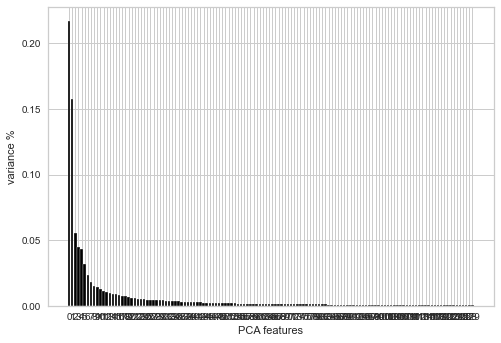

In [22]:
# Make an instance of the Model
from yellowbrick.cluster import KElbowVisualizer


variance = 0.9 #The higher the explained variance the more accurate the model will remain, but more dimensions will be present
pca = PCA(variance )

principalComponents = pca.fit(X_std) #fit the data according to our PCA instance

principalComponents = pca.transform(X_std)

print("Number of components before PCA  = " + str(X_std.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_))  #dimension reduced 


# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

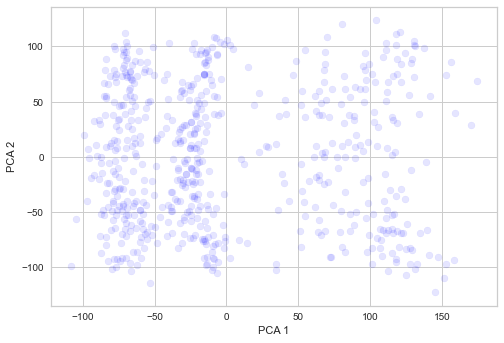

In [23]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

C:\Users\Eman Badr\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


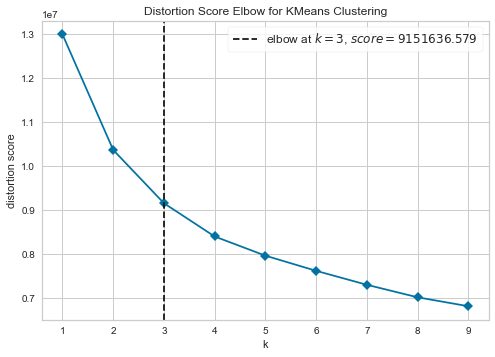

Optimal number of clusters: 3


In [24]:
#programmatically locate the elbow usuing Yellowbrick library

visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=(1,10), timings=False)
visualizer.fit(principalComponents)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

In [25]:
km = KMeans(n_clusters= n_clusters, init='k-means++', n_init=10, max_iter=300)
y_km = km.fit_predict(principalComponents)

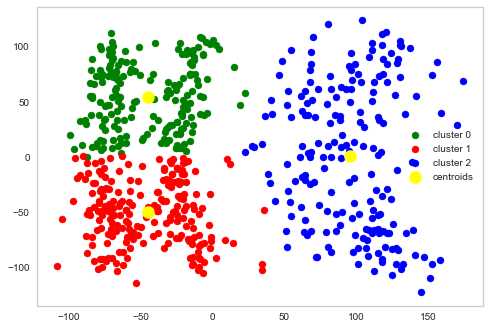

In [26]:
# plot the 3 clusters
plt.scatter(principalComponents[y_km == 0, 0], principalComponents[y_km == 0, 1], s=50, c='green', marker='o', label='cluster 0')

plt.scatter(principalComponents[y_km == 1, 0], principalComponents[y_km == 1, 1], s=50, c='red', marker='o', label='cluster 1')

plt.scatter(principalComponents[y_km == 2, 0], principalComponents[y_km == 2, 1],s=50, c='blue',marker='o',label='cluster 2')

# plot the centroids
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=150, marker='o',c='yellow',label='centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [27]:
#To visualise the data inversed from PCA
approximation = pca.inverse_transform(principalComponents)
print("Dimension of our data after inverse transforming the PCA  = " + str(approximation.shape))

Dimension of our data after inverse transforming the PCA  = (600, 24064)


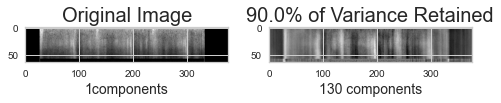

In [28]:
#image reconstruction using the less dimensioned data

plt.figure(figsize=(8,4))
n = 500 #index value, change to view different data

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(data2[n].reshape(data[0].shape[2], data[0].shape[3]), cmap = plt.cm.gray,)
plt.xlabel(str(data[0].shape[1])+'components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 196 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[n].reshape(data[0].shape[2], data[0].shape[3]), cmap = plt.cm.gray,)
plt.xlabel(str(principalComponents.shape[1]) +' components', fontsize = 14)
plt.title(str(variance * 100) + '% of Variance Retained', fontsize = 20);

In [29]:
k_means_labels = km.labels_#List of labels of each dataset
print(k_means_labels.shape)
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))

(600,)
The list of labels of the clusters are [0 1 2]


In [30]:
#by using K_means_labels, categorite each label in correct cluster and index them 

#Number of labels
G = len(np.unique(k_means_labels)) 
print(G)

#2D matrix  for an array of indexes of the given label

cluster_index = [[] for i in range(G)]


for i, label in enumerate(k_means_labels):
    for n in range(G):
        #print(k_means_labels)
        if label == n:
            cluster_index[n].append(i)
        else:
            continue



3


In [31]:
Y_clust = [[] for i in range(G)]

for n in range(G):
    Y_clust[n] = data[1][cluster_index[n]] #ex: Y_clust[0] contains array of "correct" category from label_train for the cluster_index[0]
    assert(len(Y_clust[n]) == len(cluster_index[n])) #dimension confirmation
    

In [32]:
#counts the number of each category in each cluster

def counter(cluster):
    unique, counts = np.unique(cluster, return_counts=True)
    label_index = dict(zip(unique, counts))
    return label_index


label_count= [[] for i in range(G)]

for n in range(G):
    label_count[n] = counter(Y_clust[n])

label_count 

[{0: 94, 1: 3, 2: 97}, {0: 106, 1: 5, 2: 103}, {1: 192}]

In [33]:
class_names = {0:'Concetert', 1:'Flaltmountain',2: 'Grass'} #Dictionary of class names

#A function to plot a bar graph for visualising the number of items of certain category in a cluster
def plotter(label_dict):
    plt.bar(range(len(label_dict)), list(label_dict.values()), align='center')
    a = []
    for i in [*label_dict]: a.append(class_names[i])
    plt.xticks(range(len(label_dict)), list(a), rotation=45, rotation_mode='anchor')

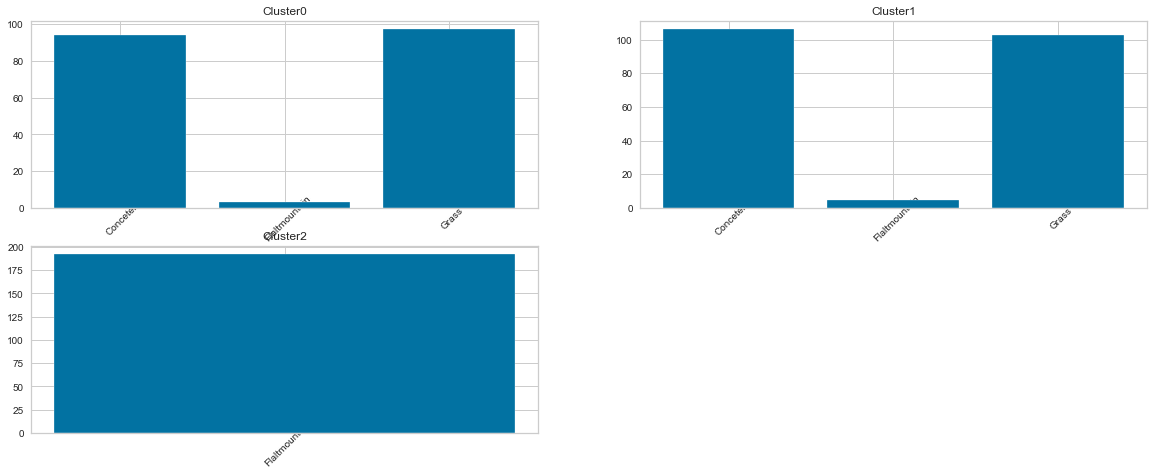

In [34]:
#Bar graph with the number of items of different categories clustered in it
plt.figure(figsize=(20,20))
for i in range (1,4):
    plt.subplot(5, 2, i)
    plotter(label_count[i-1]) 
    plt.title("Cluster" + str(i-1))